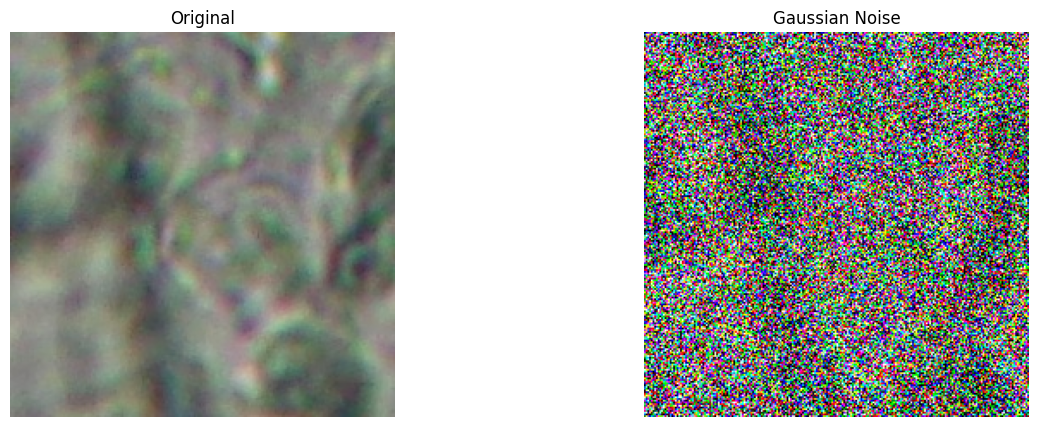

In [23]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transform(img)

def add_gaussian_noise(image, mean=-0.1, std=0.25):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)

def add_uniform_noise(image, mean=-0.1, size=1):
    noise = (2 * torch.rand_like(image) - 1) * size + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)

def add_speckle_noise(image, std=0.5):
    noise = torch.randn_like(image) * std
    noisy_image = image + image * noise
    return torch.clamp(noisy_image, 0, 1)

def show_images(original, noisy_images, titles):
    fig, axes = plt.subplots(1, len(noisy_images) + 1, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i, (img, title) in enumerate(zip(noisy_images, titles)):
        axes[i + 1].imshow(img.permute(1, 2, 0))
        axes[i + 1].set_title(title)
        axes[i + 1].axis("off")

    plt.show()

# Load image and generate noisy variants
image_path = "/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Test/0022.jpg"
image = load_image(image_path)

noisy_images = [
    add_uniform_noise(image)
]

titles = ["Gaussian Noise", "Speckle Noise"]
show_images(image, noisy_images, titles)

In [24]:
import os

def noise_statistics(directory):
    mean = 0
    std = 0
    for filename in os.listdir(directory):
        filepath = os.path.abspath(os.path.join(directory, filename))
        image = load_image(filepath)
        mean += torch.mean(image)
        std += torch.std(image)

    mean /= len(os.listdir(directory))
    std /= len(os.listdir(directory))
    print(f"Mean: {mean:.4f}, Std Dev: {std:.4f}")
'''
print("clean:")
noise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Test")
print("class 0:")
noise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/0")
print("class 1:")
noise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/1")
print("class 3:")
noise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/3")
'''

'\nprint("clean:")\nnoise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Test")\nprint("class 0:")\nnoise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/0")\nprint("class 1:")\nnoise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/1")\nprint("class 3:")\nnoise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/3")\n'

In [25]:
import math
math.sqrt(0.25 ** 2 - 0.06 ** 2)

def add_noise_statistics(directory):
    mean = 0
    std = 0
    for filename in os.listdir(directory):
        filepath = os.path.abspath(os.path.join(directory, filename))
        image = load_image(filepath)
        noise = (2 * torch.rand_like(image) - 1) * 0.7 - 0.1
        noisy_image = torch.clamp(image + image * noise, 0, 1)
        mean += torch.mean(noisy_image)
        std += torch.std(noisy_image)

    mean /= len(os.listdir(directory))
    std /= len(os.listdir(directory))
    print(f"Mean: {mean:.4f}, Std Dev: {std:.4f}")

print("noisy:")
# add_noise_statistics("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Test")

noisy:


In [26]:
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # Read CSV file
        self.root_dir = root_dir  # Use the correct root directory
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 1])  # Combine root and image path
        
        # Debugging: Check if the file exists
        if not os.path.exists(img_path):
            print(f"⚠️ Warning: File not found - {img_path}")  
        
        image = Image.open(img_path).convert('RGB')  # Load image
        id = int(self.data.iloc[idx, 0])  # Get id
        
        if self.transform:
            image = self.transform(image)

        return image, id

    def __len__(self):
        return len(self.data)

Epoch [1/20], Loss: 0.0063
Epoch [2/20], Loss: 0.0050
Epoch [3/20], Loss: 0.0037
Epoch [4/20], Loss: 0.0031
Epoch [5/20], Loss: 0.0028
Epoch [6/20], Loss: 0.0027
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0016
Epoch [9/20], Loss: 0.0017
Epoch [10/20], Loss: 0.0016
Epoch [11/20], Loss: 0.0015
Epoch [12/20], Loss: 0.0015
Epoch [13/20], Loss: 0.0015
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0015
Epoch [16/20], Loss: 0.0015
Epoch [17/20], Loss: 0.0015
Epoch [18/20], Loss: 0.0015
Epoch [19/20], Loss: 0.0015
Epoch [20/20], Loss: 0.0014


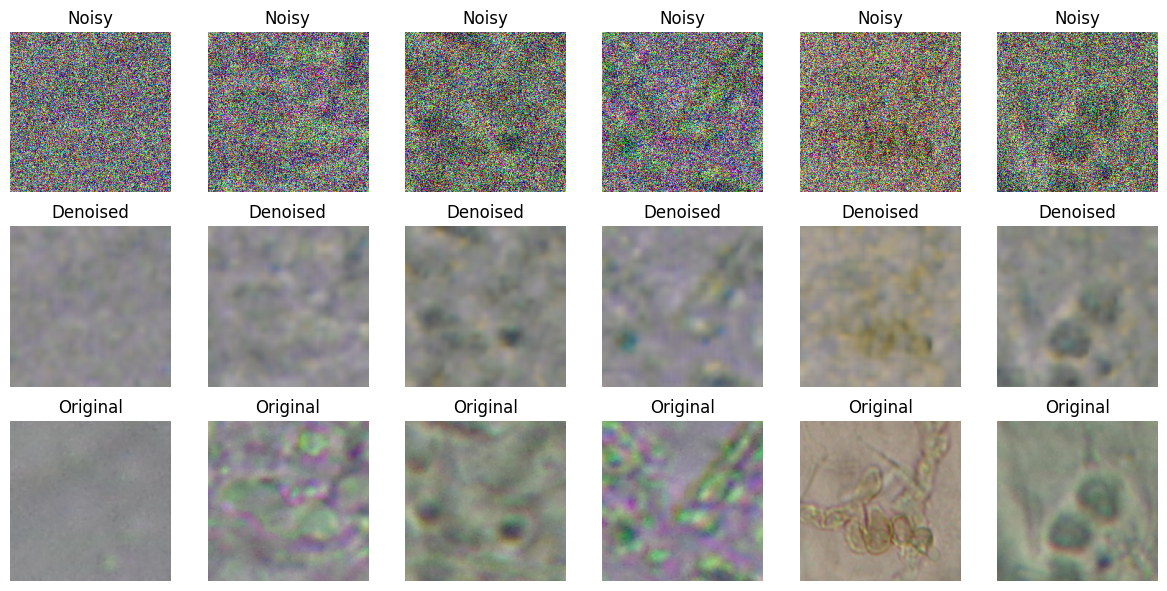

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

# Define the Denoising Autoencoder architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder: reduce image dimensions while capturing features
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Output: [64, 112, 112]
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: [128, 56, 56]
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Output: [256, 28, 28]
            nn.ReLU(True),
        )
        # Decoder: reconstruct the image back to original size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [128, 56, 56]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: [64, 112, 112]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # Output: [3, 224, 224]
            nn.Sigmoid(),  # Use Sigmoid since pixel values are normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Function to add Gaussian noise to images
def add_noise(inputs, noise_factor=0.7, mean=-0.1):
    noisy = inputs + noise_factor * (2 * torch.rand_like(inputs) - 1) + mean
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure images are 224x224
    transforms.ToTensor(),
])

csv_file = "/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/fungi_test.csv"
root_dir = "/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles"
train_dataset = TestDataset(csv_file, root_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()  # Measure the difference between reconstructed and original images
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        # Create noisy images as input
        noisy_images = add_noise(images)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Visualize some denoising results
model.eval()
dataiter = iter(train_loader)
images, _ = next(dataiter)
noisy_images = add_noise(images)
images = images.to(device)
noisy_images = noisy_images.to(device)

with torch.no_grad():
    outputs = model(noisy_images)

# Function to display an image
def imshow(img, title):
    img = img.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Plot original, noisy, and denoised images
num_images = 6
plt.figure(figsize=(12, 6))
for idx in range(num_images):
    plt.subplot(3, num_images, idx + 1)
    imshow(noisy_images[idx], "Noisy")
    
    plt.subplot(3, num_images, idx + 1 + num_images)
    imshow(outputs[idx], "Denoised")
    
    plt.subplot(3, num_images, idx + 1 + 2*num_images)
    imshow(images[idx], "Original")

plt.tight_layout()
plt.show()

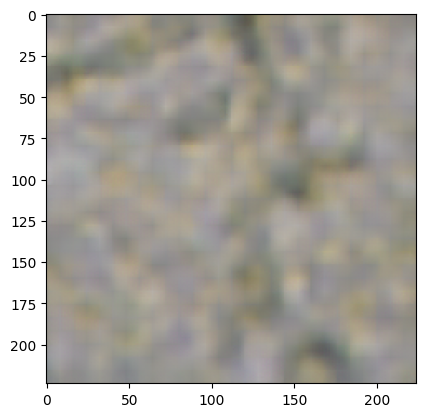

In [30]:
model.eval()
noisy = load_image("/kaggle/input/ds-3-datathon-2025-fungi-classification/DatathonFiles/Train/1/1_0022.jpg")
noisy = noisy.to(device)
with torch.no_grad():
    output = model(noisy)

plt.imshow(output.cpu().numpy().transpose(1, 2, 0))
plt.show()

In [31]:
torch.save(model.state_dict(), "dae.pth")